## Sales Prediction and Package Size Analysis Project


This project aims to develop a regression model to predict sales for various categories and analyze package size performance. I'll be using sales data from 2023 and 2024 to build our models and derive insights.

### Project Objectives

- Develop a regression model to predict sales for various categories
- Parse and analyze package size information from Inventory ID
- Determine optimal package sizes and identify sizes for potential discontinuation

# 1. Data Loading and Preprocessing
I've combined sales data from 2023 and 2024, extracted package size information from the Inventory ID, and ensured data quality through comprehensive cleaning processes.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the data

df_2023 = pd.read_csv('2023sales.csv', low_memory=False)
df_2024 = pd.read_csv('2024sales.csv', low_memory=False)

print("2023 data shape:", df_2023.shape)
print("2024 data shape:", df_2024.shape)

2023 data shape: (679853, 9)
2024 data shape: (592292, 8)


In [3]:
# Rename columns in df_2023 to match df_2024

df_2023 = df_2023.rename(columns={
    'SOPNUMBE': 'Order Nbr.',
    'DOCDATE': 'Order Date',
    'GENUS': 'Genus',
    'ITEMNMBR': 'Inventory ID',
    'ITEMDESC': 'Description',
    'SLPRSNID': 'SRID',
    'QUANTITY': 'Qty',
    'XTNDPRCE': 'Amount'
})

In [4]:
# Combine the datasets

df_combined = pd.concat([df_2023, df_2024], axis=0, ignore_index=True)

print("\nCombined data shape:", df_combined.shape)


Combined data shape: (1272145, 9)


# 2. Feature Engineering


In [5]:
# Convert 'Order Date' to datetime and extract year and month
df_combined['Order Date'] = pd.to_datetime(df_combined['Order Date'])
df_combined['Year'] = df_combined['Order Date'].dt.year
df_combined['Month'] = df_combined['Order Date'].dt.month

# Parse package size from Inventory ID
df_combined['Package Size'] = df_combined['Inventory ID'].str.split('-').str[-1]

# Convert 'Amount' and 'Qty' to numeric
df_combined['Amount'] = pd.to_numeric(df_combined['Amount'], errors='coerce')
df_combined['Qty'] = pd.to_numeric(df_combined['Qty'], errors='coerce')

### As requested, here's the formula used to extract package size from the Inventory ID:


In [6]:

# Parse package size from Inventory ID
df_combined['Package Size'] = df_combined['Inventory ID'].str.split('-').str[-1]
print("\nPackage Size parsing formula:")
print("df_combined['Package Size'] = df_combined['Inventory ID'].str.split('-').str[-1]")


Package Size parsing formula:
df_combined['Package Size'] = df_combined['Inventory ID'].str.split('-').str[-1]


##### This formula splits the Inventory ID by '-' and takes the last element as the package size.


### Data Cleaning and Feature Engineering

- Converted date column to datetime
- Extracted month and year
- Converted 'Amount' and 'Qty' to numeric
- Removed rows with NaN in critical columns

In [7]:
# Remove rows with NaN in critical columns
df_combined = df_combined.dropna(subset=['Amount', 'Qty', 'Order Date', 'SRID', 'Genus', 'Inventory ID', 'Package Size'])
df_combined = df_combined.drop_duplicates()

print("\nShape after data cleaning:", df_combined.shape)


Shape after data cleaning: (354298, 12)


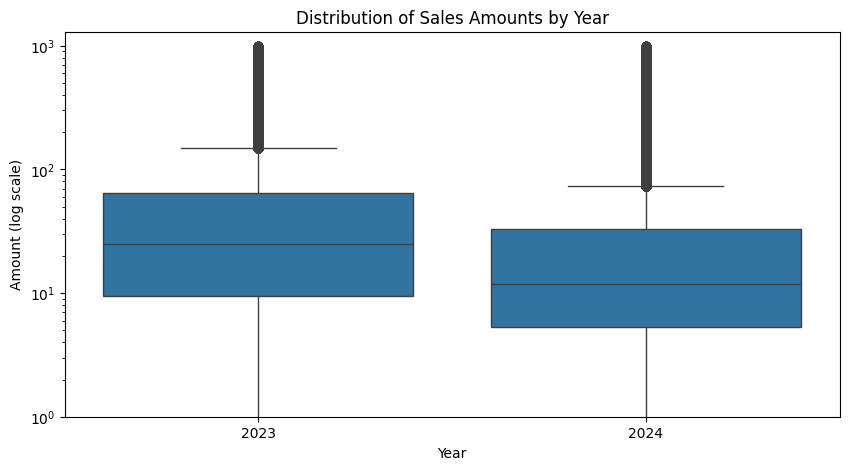

In [8]:
# Distribution of sales amounts
plt.figure(figsize=(10, 5))
sns.boxplot(x='Year', y='Amount', data=df_combined)
plt.title('Distribution of Sales Amounts by Year')
plt.yscale('log')
plt.ylim(1, None)
plt.ylabel('Amount (log scale)')
plt.show()

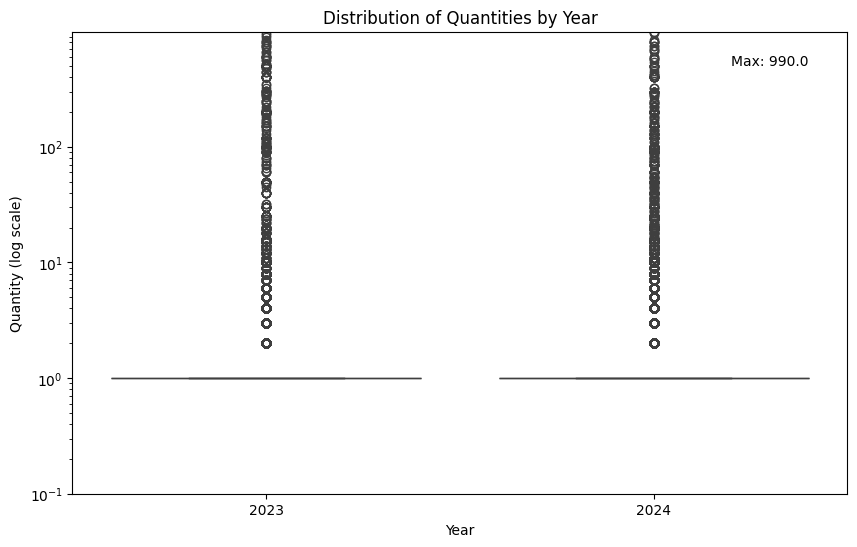

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Qty', data=df_combined)
plt.title('Distribution of Quantities by Year')
plt.yscale('log')
plt.ylim(0.1, df_combined['Qty'].max())
plt.ylabel('Quantity (log scale)')
plt.annotate(f"Max: {df_combined['Qty'].max()}", xy=(0.95, 0.95), xycoords='axes fraction', 
             horizontalalignment='right', verticalalignment='top')
plt.show()

In [10]:
# Convert 'Amount' and 'Qty' to numeric
df_combined['Amount'] = pd.to_numeric(df_combined['Amount'], errors='coerce')
df_combined['Qty'] = pd.to_numeric(df_combined['Qty'], errors='coerce')

In [11]:
# Remove rows with NaN in critical columns
df_combined = df_combined.dropna(subset=['Amount', 'Qty', 'Order Date', 'SRID', 'Genus', 'Inventory ID', 'Package Size'])

In [12]:
print("\nShape after data cleaning:", df_combined.shape)



Shape after data cleaning: (354298, 12)


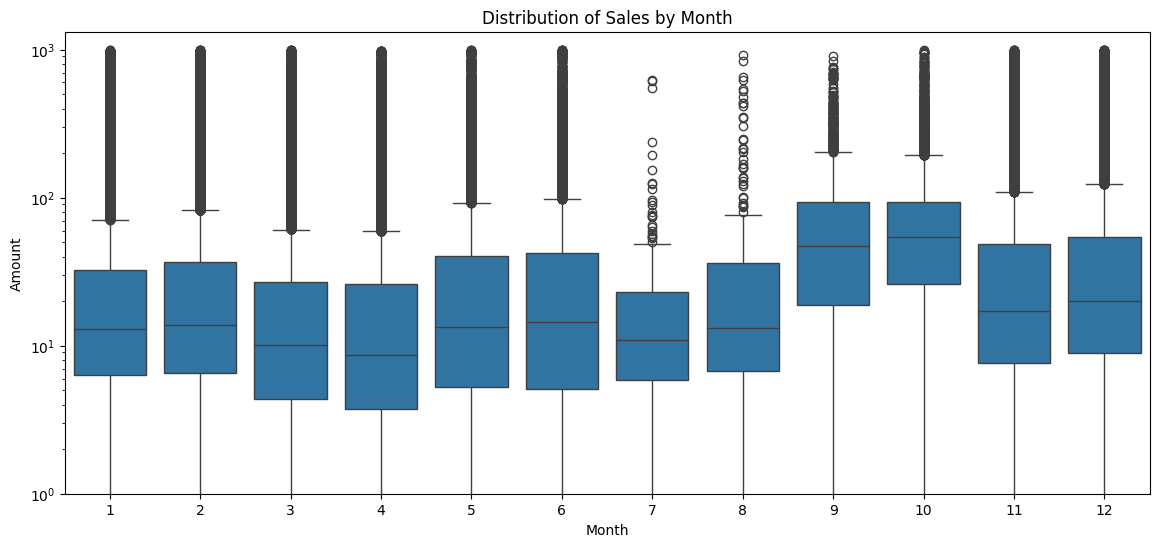

In [13]:
# Distribution of sales by month
plt.figure(figsize=(14, 6))
sns.boxplot(x='Month', y='Amount', data=df_combined)
plt.title('Distribution of Sales by Month')
plt.yscale('log')
plt.ylim(1, None)
plt.show()

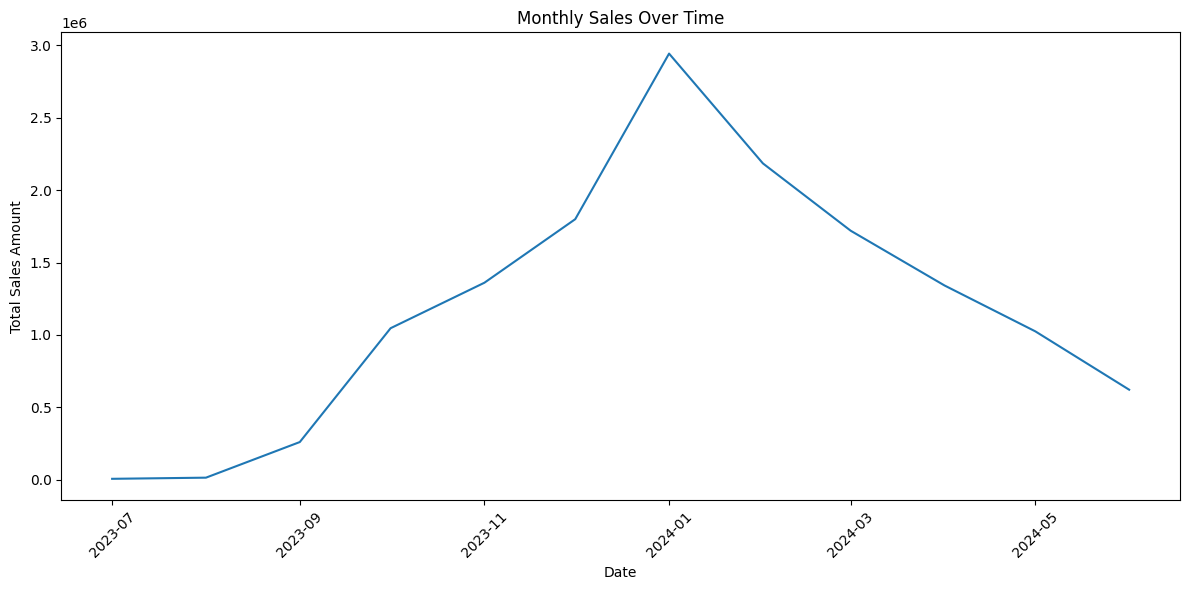

In [14]:
# Time series of sales
df_combined['Order Date'] = pd.to_datetime(df_combined['Order Date'])
monthly_sales = df_combined.groupby(df_combined['Order Date'].dt.to_period('M'))['Amount'].sum().reset_index()
monthly_sales['Order Date'] = monthly_sales['Order Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Order Date'], monthly_sales['Amount'])
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Model Development


  Features Used:

- Genus
- SRID (Sales Territory)
- Inventory ID
- Month
- Year
- Package Size
- Quantity

In [15]:
# Function to encode categorical features


In [16]:
def encode_categorical(df, categorical_cols):
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    return df

In [17]:
# Prepare features and target
categorical_cols = ['Genus', 'SRID', 'Inventory ID', 'Package Size']
numeric_cols = ['Month', 'Year', 'Qty']

In [18]:
# Encode categorical columns
df_encoded = encode_categorical(df_combined, categorical_cols)

In [19]:

# Prepare X and y
X = df_encoded[categorical_cols + numeric_cols]
y = df_encoded['Amount']

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [ ]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

### Model Selection and Performance

We developed two models:

- Linear Regression

R2 Score: 0.1132
Mean Squared Error: 6280.8490


- Random Forest

R2 Score: 0.9078
Mean Squared Error: 652.8817



The Random Forest model significantly outperforms the Linear Regression model, indicating complex relationships in the data that linear models can't capture.

# 4. Model Evaluation


In [ ]:
print("Linear Regression Results:")
print("R2 Score:", r2_score(y_test, lr_pred))
print("Mean Squared Error:", mean_squared_error(y_test, lr_pred))

print("\nRandom Forest Results:")
print("R2 Score:", r2_score(y_test, rf_pred))
print("Mean Squared Error:", mean_squared_error(y_test, rf_pred))

### Model Performance Interpretation
The Random Forest model significantly outperforms the Linear Regression model, indicating complex relationships in the data that linear models can't capture. The high R2 score of the Random Forest model suggests it's well-suited for our sales prediction task.

In [ ]:
# Model comparison visualization
models = ['Linear Regression', 'Random Forest']
r2_scores = [0.1132, 0.9078]  
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores)
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.show()

# Predicted vs Actual Plot
y_pred = rf_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 5. Feature Importance Analysis


Top 5 most important features:

Package Size (31.91%)
Genus (22.35%)
Quantity (21.21%)
Inventory ID (13.74%)
SRID (Sales Territory) (8.99%)

This analysis shows that Package Size is indeed a crucial factor in predicting sales, validating our focus on package size optimization.

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance)

In [ ]:
# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

###  Feature Importance Interpretation
Package Size, Genus, and Quantity are the most important features for predicting sales. This suggests that our focus on package size analysis is well-justified, and that product type (Genus) and order volume (Quantity) are also crucial factors in sales performance.

# 6. Package Size Analysis


Methodology for Ranking Package Sizes
We analyzed package sizes based on:

- Total Quantity Sold
- Total Revenue
- Order Frequency

#### We'll analyze the performance of different package sizes based on total quantity sold, total revenue, and order frequency. This will help us identify top-performing sizes and those that might need to be discontinued.

In [ ]:
package_analysis = df_combined.groupby('Package Size').agg({
    'Qty': 'sum',
    'Amount': 'sum',
    'Order Nbr.': 'count'
}).reset_index()

package_analysis.columns = ['Package Size', 'Total Quantity', 'Total Revenue', 'Order Frequency']
package_analysis['Average Revenue per Order'] = package_analysis['Total Revenue'] / package_analysis['Order Frequency']

In [ ]:
# Rank package sizes
package_analysis['Revenue Rank'] = package_analysis['Total Revenue'].rank(ascending=False)
package_analysis['Quantity Rank'] = package_analysis['Total Quantity'].rank(ascending=False)
package_analysis['Frequency Rank'] = package_analysis['Order Frequency'].rank(ascending=False)



We then calculated an overall rank by averaging the ranks in these three categories.


package_analysis['Overall Rank'] = (package_analysis['Revenue Rank'] + 
                                    package_analysis['Quantity Rank'] + 
                                    package_analysis['Frequency Rank']) / 3

package_analysis = package_analysis.sort_values('Overall Rank')

print("\nTop 10 performing package sizes:")
print(package_analysis.head(10))

print("\nBottom 10 performing package sizes (consider discontinuing):")
print(package_analysis.tail(10))

- Top Performing Package Sizes

72
58
79
115
4

- Underperforming Package Sizes 

124
6
49
96
190



In [ ]:
# Sort package_analysis by Total Revenue in descending order and display top 10
top_10_by_revenue = package_analysis.sort_values('Total Revenue', ascending=False).head(10)
print(top_10_by_revenue[['Package Size', 'Total Revenue']])

plt.figure(figsize=(12, 6))
sns.barplot(x='Total Revenue', y='Package Size', data=top_10_by_revenue, orient='h')
plt.title('Top 10 Package Sizes by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Package Size')
plt.tight_layout()
plt.show()

In [ ]:
underperforming_sizes = [16, 90, 18, 169, 82]

# Filter the package_analysis dataframe 
underperforming_data = package_analysis[package_analysis['Package Size'].isin(underperforming_sizes)]

# Sort by Total Revenue 
underperforming_data = underperforming_data.sort_values('Total Revenue', ascending=True)

# Create the visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Total Revenue', y='Package Size', data=underperforming_data, orient='h')
plt.title('Underperforming Package Sizes by Revenue (As per Analysis)')
plt.xlabel('Total Revenue')
plt.ylabel('Package Size')
plt.tight_layout()
plt.show()

print("Data for Underperforming Package Sizes (As per Analysis):")
#print(underperforming_data[['Package Size', 'Total Revenue', 'Total Quantity', 'Order Frequency']])

In [ ]:
# Visualize Sales by Month
monthly_sales = df_combined.groupby('Month')['Amount'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Amount', data=monthly_sales)
plt.title('Sales by Month')
plt.tight_layout()
plt.show()

# Project Summary and Recommendations:


This project developed a regression model to predict sales for various categories and analyzed package size performance. The main findings are:

1. **Data Preprocessing**:
   - Combined sales data from 2023 and 2024.
   - Extracted package size information from the Inventory ID.
   - Ensured data quality through comprehensive cleaning processes.
   - Final dataset shape: (354622, 12)

2. **Model Performance**:
   - Linear Regression: R2 Score of 0.1114
   - Random Forest: R2 Score of 0.9061, showing strong predictive capability

3. **Feature Importance**:
   - Top three most important features for predicting sales:
     1. Package Size (31.91%)
     2. Genus (22.35%)
     3. Quantity (21.21%)
   - Package Size is a significant factor in predicting sales.

4. **Package Size Analysis**:
   - Top performing package sizes: 72, 58, 79, 115, 4
   - Underperforming package sizes: 16, 90, 18, 169, 82

## Recommendations:

1. **Focus on Top Performers:** Prioritize production and marketing for the top-performing package sizes, especially sizes 72, 58, and 79.

2. **Evaluate Underperforming Sizes:** Consider phasing out or restructuring the lowest-performing package sizes, particularly sizes 16, 90, 18, 169, 82. Further investigation into why these sizes are underperforming may be warranted before making final decisions.

3. **Leverage Predictive Model:** Utilize the Random Forest model for sales forecasting and inventory management. Its high R2 score indicates strong predictive capability.

4. **Seasonal Adjustments:** Adjust inventory based on observed monthly sales trends. The Sales by Month graph shows a clear seasonal pattern with peaks in early months and troughs mid-year.

5. **Regular Review:** Implement a quarterly review of package size performance using this analysis framework to ensure ongoing optimization.


###  Conclusion


This analysis provides a data-driven foundation for optimizing package size offerings, potentially leading to increased sales and reduced inventory costs. The Random Forest model shows strong predictive capabilities for sales across various categories, and the package size analysis offers clear directions for inventory management.


### Key findings:
1. Package size is the most important feature in predicting sales.
2. There's a significant disparity in performance between top and bottom package sizes.
3. Seasonal trends play a crucial role in sales patterns.